# Introduction

Time Series Decomposition is a method for separating the overall time series data into multiple components that, when recombined, constitue the original time series.  The value of this is that identifying each component often enables us to think about the factors that influence that sub-component directly and, thus, better understand the data and what causes the overall pattern we see.  Also, decomposing time series data permits us to forecast how the overall time series will behave into the future based on our understanding of the separate components and what is driving them.

The image below is from the William S. Cleveland book _The Elements of Graphing Data_, and it is an excellent example of time series decompostion.  It identifies and overall trend, a seasonal pattern, and some oscillation that is somewhat regular.  There is always some part of the pattern that doesn't follow a regular pattern and we call that the Remainder or, sometimes, Noise.

![Cleveland Time Series Decomposition](ClevelandTimeSeriesDecomposition.jpg)

## Example 1: Demand Pattern Decomposition

Experience would suggest that this first example is obviously fictious data because its patterns are significantly more consistent across time than  real-world data.  Nonetheless, it is a good first exercise, particularly, because the obvious patterns make this first exercise easier than is normally the case.

This data was adapted from the textbook _Supply Chain Management: 3rd Edition_, by Sunil Chopra and Peter Meindl,  Prentice Hall, 2006.

We will be using matplotlib, numpy, and pandas, so let's import those packages now, as well as execute the matplotlib magic command.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Read the data.

In [20]:
df = pd.read_csv('TSDataP1.csv')
df.head()

,Quarter,Product1Demand
0,1,152400
1,2,185000
2,3,182880
3,4,161544
4,5,166116


Let's look at the data, first, to begin to understand it.

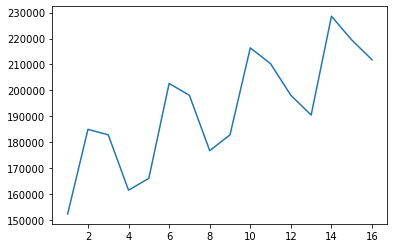

In [21]:
plt.plot(df.Quarter,df.Product1Demand)

Describe the pattern in this graph?  What "component patterns" do you see within the overall graph?

At this point you should observe an overall (positive) trend  and seasonality.  To perceive the trend, ask what results a linear regression analysis would yield for intercept and slope.  Perhaps, you will intuit that the trend in this graph is a linear one rather than a nonlinear one.

You could, and should ask yourself what is causing those patterns.  You may know the causes from experience if you are familiar with the context or, alternately, you may need to do research to determine the causes.  If you were a consultant, you might well be in the latter position.

Our goal now is to decompose these data.  Doing so will enable us to forecast demand into the future because the components are easier to detect and express individually, so that we may extrapolate them into the future.  We need to assume a functional form for how the components contribute to the overall pattern in order to guide the math that we do.  For our purposes, we will assume this model, which is called an additive model:

- $D$ = Product Demand 
- $q$ = the index of the quarter
- $L$ = The 'level' component of the demand pattern which is a constant value
- $T$ = The (linear) trend of the data.  This is the amount that demand increases, on average, from one quarter to the next.  T is also a constant.
- $S \left(q \right)$ = Seasonality component.  We need to figure out how many quarters there are before the seaonal pattern repeats so that we can determine the seasonality component for each quarter, $q$.
- $\epsilon \left( q \right)$ is the portion of demand that we will not be able to fit with $L$, $T \left(q \right)$ and $S \left(q \right)$.


$D\left(q \right) = L + T \left(q \right) + S \left(q \right) + \epsilon \left( q \right)$ 

We can easily get $L$ and $T$ from a linear regression analysis.  We will use a new Python package for this analysis.  Many Python packages can do this analysis well.  

In [22]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['Product1Demand'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 165969.76470588235     slope = 3567.764705882353      p_value =  0.0004266677252921289


Now we need to 'remove' the trend and the level from the original demand pattern to see what pattern remains for use to describe seasonality.  We use the DataFrame.apply() method from pandas to compute the value for each quarter from the regression model, which we will put in a column called _regress_.  then we will subtract that part of the "signal" from the original sales trajectory and put the remainder in a column called _R1_ for 1st remainder.

Notice the last block of code, which formats the columns of the DataFrame if you haven't seen this technique previously.

In [23]:
def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row['Quarter']) * slope
    
df['regress'] = df.apply(create_regress_col,args = (intercept,slope),axis = "columns")
df['R1'] = df['Product1Demand'] - df['regress']
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format
})

,Quarter,Product1Demand,regress,R1
0,1,"152,400","169,538","-17,138"
1,2,"185,000","173,105","11,895"
2,3,"182,880","176,673","6,207"
3,4,"161,544","180,241","-18,697"
4,5,"166,116","183,809","-17,693"
5,6,"202,692","187,376","15,316"
6,7,"198,120","190,944","7,176"
7,8,"176,784","194,512","-17,728"
8,9,"182,880","198,080","-15,200"
9,10,"216,408","201,647","14,761"


Here is a plot of the R1 data column.

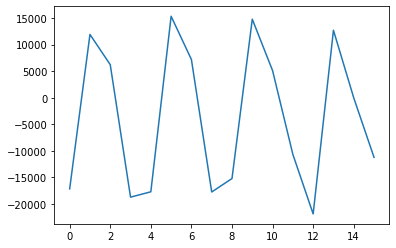

In [24]:
plt.plot(df.index,df.R1)

This looks like a repeated pattern.

How many quarters pass before the pattern repeats?

When the autocorrelation value for a particular lag is large and positive (close to 1), it indicates a cyclic pattern with the periodicity of that lag.

   Quarter  Product1Demand        regress            R1      lag4
0        1          152400  169537.529412 -17137.529412       NaN
1        2          185000  173105.294118  11894.705882       NaN
2        3          182880  176673.058824   6206.941176       NaN
3        4          161544  180240.823529 -18696.823529       NaN
4        5          166116  183808.588235 -17692.588235  152400.0
5        6          202692  187376.352941  15315.647059  185000.0
6        7          198120  190944.117647   7175.882353  182880.0
7        8          176784  194511.882353 -17727.882353  161544.0
8        9          182880  198079.647059 -15199.647059  166116.0
9       10          216408  201647.411765  14760.588235  202692.0
autocorrelation, lag = 0 : 1.0
autocorrelation, lag = 1 : -0.1102785302304148
autocorrelation, lag = 2 : -0.8689094084728753
autocorrelation, lag = 3 : 0.022736719932132617
autocorrelation, lag = 4 : 0.9658506974344425
autocorrelation, lag = 5 : -0.08723019865257427
autocor

C:\Users\jmert\miniconda3\envs\python\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Text(0.5, 0, 'Quarter')

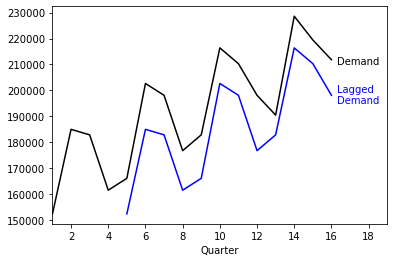

In [25]:
# Create column with lag of 4
lag = 4
df['lag4'] = np.NaN
for i in range(len(df['lag4']))[lag:]:
    df['lag4'].iloc[i] = df['Product1Demand'].iloc[i-4]
print(df.head(n=10))

# Compute autocorrelations
for i in range(int(len(df.index)/2)):
    print('autocorrelation, lag =',i,':',df.R1.autocorr(lag = i))
    
fig,ax = plt.subplots()
ax.plot(df.Quarter,df.Product1Demand,c='k')
ax.plot(df.Quarter,df.lag4,c='b')
ax.set_xlim([1,19])
ax.text(16.3,210000,'Demand',color='k')
ax.text(16.3,195000,'Lagged\nDemand',color='b')
ax.set_xlabel('Quarter')

This code plots each sequential series of 4 points, where 4 corresponds with the periodicty of the data.  Note how the patterns have similar shapes, which is why the autocorrelation with this lag was nearly 1.  Let's create a graph that demonstrates this by plotting each successive group of four points.

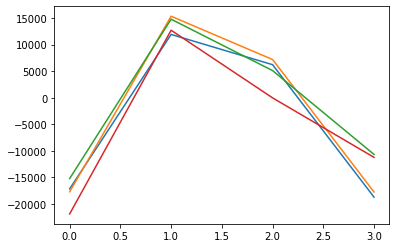

In [26]:
dfQtr = pd.DataFrame()
cycleLen = 4
for i in range(int(len(df.index)/cycleLen)):
    newData = pd.DataFrame({i:df['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfQtr = pd.concat([dfQtr,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfQtr)

If we average the demand for each of the seasonal quarters, so those averages represent all the curves well?

              0             1             2             3           avg
0 -17137.529412 -17692.588235 -15199.647059 -21850.705882 -17970.117647
1  11894.705882  15315.647059  14760.588235  12681.529412  13663.117647
2   6206.941176   7175.882353   5096.823529    -30.235294   4612.352941
3 -18696.823529 -17727.882353 -10662.941176 -11218.000000 -14576.411765


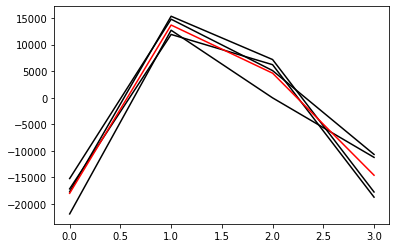

In [27]:
avg = []
for i in range(len(dfQtr.index)):
    avg.append(dfQtr.iloc[i].mean())

dfQtr = pd.concat([dfQtr,pd.DataFrame({'avg':avg})], axis=1)
print(dfQtr)

fig,ax = plt.subplots()
c = 180
for col in dfQtr.columns.values:
    if col == 'avg':
        ax.plot(dfQtr[col], c = 'r')
    else:
        ax.plot(dfQtr[col], c = 'k')

What does the remainder of the demand pattern look like if we use the average seasonality?

The code below assigns a seasonal component of sales to each quarter based on the average that was computed above and puts it in a column named _S_.

Next, The 2nd remainder is computed, _R2_, which is the difference between the original sales trajectory and the sum of the regression model and the seasonal component, $L + T \left(q \right) + S \left(q \right)$.  That is, if you look at the oriignal mathematical model, the values in _R2_ are equal to the term $ \epsilon \left( q \right)$ in the model.

A column named _Composite_ is computed, whcih is the sum of the regression model and seasonal effects, and the percentage error is computed in the columne _errorPerc_.

In [28]:
df['S'] = np.NaN
df['R2'] = np.NaN
df['Composite'] = np.NaN
df['errorPerc'] = np.NaN
S = dfQtr['avg'].tolist()
for i in df.index:
    df.loc[i,'S'] = S[i%cycleLen]
    df.loc[i,'R2'] = df.loc[i,'R1'] - df.loc[i,'S']
    df.loc[i,'Composite'] = df.loc[i,'regress'] + df.loc[i,'S']
    df.loc[i,'errorPerc'] = 100*df.loc[i,'R2'] / df.loc[i,'Product1Demand']
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format,
    'S': '{:,.0f}'.format,
    'R2': '{:,.0f}'.format,
    'Composite':'{:,.0f}'.format,
    'errorPerc': '{:.2f}%'.format
})

,Quarter,Product1Demand,regress,R1,lag4,S,R2,Composite,errorPerc
0,1,"152,400","169,538","-17,138",nan,"-17,970",833,"151,567",0.55%
1,2,"185,000","173,105","11,895",nan,"13,663","-1,768","186,768",-0.96%
2,3,"182,880","176,673","6,207",nan,"4,612","1,595","181,285",0.87%
3,4,"161,544","180,241","-18,697",nan,"-14,576","-4,120","165,664",-2.55%
4,5,"166,116","183,809","-17,693",152400.000000,"-17,970",278,"165,838",0.17%
5,6,"202,692","187,376","15,316",185000.000000,"13,663","1,653","201,039",0.82%
6,7,"198,120","190,944","7,176",182880.000000,"4,612","2,564","195,556",1.29%
7,8,"176,784","194,512","-17,728",161544.000000,"-14,576","-3,151","179,935",-1.78%
8,9,"182,880","198,080","-15,200",166116.000000,"-17,970","2,770","180,110",1.51%
9,10,"216,408","201,647","14,761",202692.000000,"13,663","1,097","215,311",0.51%


Let's visualize how our model of demand fits actual product demand

Text(0, 0.5, 'Demand/Sales')

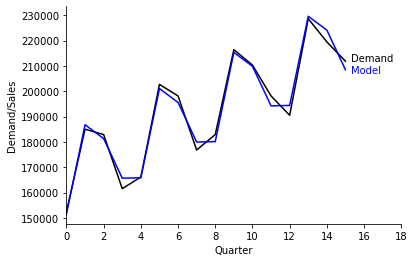

In [29]:
fig, ax = plt.subplots()
ax.plot(df['Product1Demand'],c='k')
ax.plot(df['Composite'],c='b')
ax.set_xlim([0,18])
ax.text(15.3,212000,'Demand', color='k')
ax.text(15.3,207000,'Model', color='b')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Quarter')
ax.set_ylabel('Demand/Sales')

Here is a plot of the remainder, that is, the error of our model.

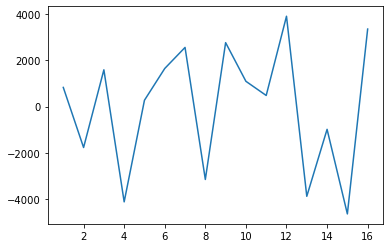

In [30]:
plt.plot(df.Quarter,df.R2)

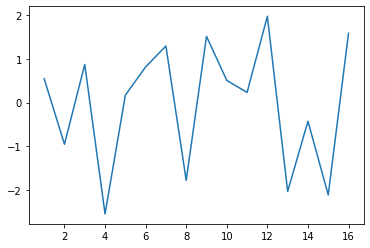

In [31]:
plt.plot(df.Quarter,df.errorPerc)

## Example 2: United States Monthly Home Sales Time Series Decomposition

This data was downloaded from the Internet (link to be added) and it portrays monthly home sales in the United States on a monthly basis where the data have _not been seasonally adjusted_ as is the case with many data sources.

We will use a similar, but more general model for the Home Sales data.  Specifically, we will use this model:

$H\left(m \right) = T\left( m \right) + C\left( m \right) + \epsilon \left( m \right)$

where

- $H\left( m \right)$ = Number of homes sold in Month $m$
- $m$ = the index of the month
- $T\left( m \right)$ = $T$ represents the trend of the data which, in this case, could be nonlinear.  $T\left( m \right)$ is the trend value for Month $m$.
- $C\left( m \right)$ = Cyclicality demand component which plays an analogous role to seasonality, $S\left( q \right)$, except that the pattern repeats after period whose duration might not be one year.
- $\epsilon \left( m \right)$ is the portion of demand that we will not be able to fit with $T \left(m \right)$ and $C \left( m \right)$.

Often, the ultimate goal of decomposing data like these is to forecast demand into the future because the components are easier to detect and express individually: once identified, each component's pattern can be extrapolated into the future and combined to create a forecast.  

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load and visualize the data

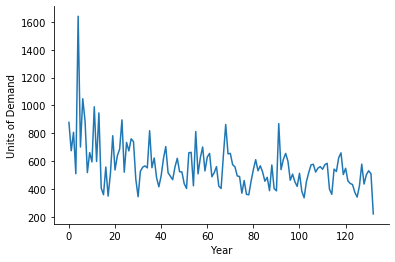

In [33]:
dfHS = pd.read_csv('homeSales.csv')

fig,ax = plt.subplots()
ax.plot(dfHS['homeSales'],label='Home Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

What type of trend do you see in the data?

The next cell of code computes the moving average of each point for a data window centered on each point.  The window size is a variable that can be easily changed, and the average squared error is computed in order to help evaluate which window size is appropriate for the moving average.

Average Squared Error per Month:  12990.722102901871
           YearMonth  homeSales      MovAvg         sqErr
2009-02-28   2009-02        509  673.916667  27197.506944
2009-03-31   2009-03        782  668.666667  12844.444444
2009-04-30   2009-04        536  663.430556  16238.546489
2009-05-31   2009-05        638  657.611111    384.595679
2009-06-30   2009-06        686  640.375000   2081.640625
...              ...        ...         ...           ...
2016-10-31   2016-10        541  501.930556   1526.421489
2016-11-30   2016-11        574  498.972222   5629.167438
2016-12-31   2016-12        584  495.708333   7795.418403
2017-01-31   2017-01        398  492.736111   8974.930748
2017-02-28   2017-02        361  488.138889  16164.297068

[97 rows x 4 columns]


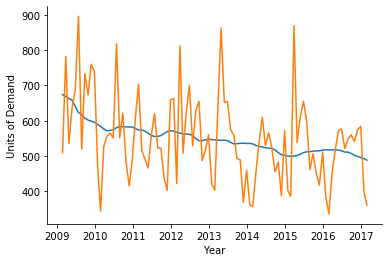

In [34]:
def sqErr(row):
    return (row['homeSales'] - row['MovAvg'])**2
    
dfHS['MovAvg'] = np.NaN
dfHS['sqErr'] = np.NaN
# Chaging the DataFrame index to DatetimeIndex data type is required for using one of the functions below
dfHS.index = pd.DatetimeIndex(freq='m', data=pd.date_range(freq='m',start=pd.Timestamp(year=2007, month=8, day=31), periods = len(dfHS['homeSales'])))
#print(len(data),'\n',data)

window = 36
window = window - window % 2
# Compute the moving average in the loop below using a window centered on the data point whose average is eing computed
for i in range(int(window/2),dfHS.shape[0]-int(window/2)):
    dfHS.loc[dfHS.index[i],'MovAvg'] = (0.5*dfHS.iloc[i - int(window/2)]['homeSales'] + dfHS.iloc[i - int(window/2)+1:i + int(window/2)]['homeSales'].sum() + 0.5*dfHS.iloc[i + int(window/2)]['homeSales'])/float(window)

dfHS['sqErr'] = (dfHS['homeSales'] - dfHS['MovAvg'])**2
# The squared error can eb computed also with the dfHA.apply() method below
# Using dfHS.apply() in this case is unecessary complexity, but it is a good function to know about
#dfHS['sqErr'] = dfHS.apply(sqErr,axis='columns')

# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
dfHS.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(dfHS['MovAvg'],label='Moving Avg.')
ax.plot(dfHS['homeSales'],label='Home Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(dfHS['sqErr'])/len(dfHS))
print(dfHS)

The residual Home Sales yet to be explained, $R1$, is computed by subtracting the moving average from the demand time series.  Also, these are included in this code cell:
- Computing $R1$ as a percentage of demand ($R1Error$).
- The dfHS.style.format command demonstrates how to display pandas DataFrame data in whicever readble format you preer.

In [35]:
dfHS['R1'] = dfHS['homeSales'] - dfHS['MovAvg']
dfHS['R1Error'] = abs((dfHS['homeSales'] - dfHS['R1'])/dfHS['homeSales'])
dfHS.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,YearMonth,homeSales,MovAvg,sqErr,R1,R1Error
2009-02-28 00:00:00,2009-02,509,673.9,"27,197.5",-164.9,1.324
2009-03-31 00:00:00,2009-03,782,668.7,"12,844.4",113.3,0.855
2009-04-30 00:00:00,2009-04,536,663.4,"16,238.5",-127.4,1.238
2009-05-31 00:00:00,2009-05,638,657.6,384.6,-19.6,1.031
2009-06-30 00:00:00,2009-06,686,640.4,"2,081.6",45.6,0.933
2009-07-31 00:00:00,2009-07,896,623.3,"74,377.4",272.7,0.696
2009-08-31 00:00:00,2009-08,520,617.3,"9,473.8",-97.3,1.187
2009-09-30 00:00:00,2009-09,734,607.4,"16,023.3",126.6,0.828
2009-10-31 00:00:00,2009-10,673,601.9,"5,052.8",71.1,0.894
2009-11-30 00:00:00,2009-11,760,598.8,"25,970.2",161.2,0.788


The cell below helps us visualize the remaining pattern to be decomposed, $R1$, and it also computes the average residual demand pattern.

Average Residual:  -0.8771477663230256


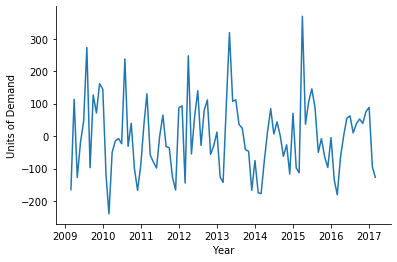

In [36]:
fig,ax = plt.subplots()
ax.plot(dfHS['R1'])
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(dfHS['R1'])/len(dfHS))

Just as seasonal demand had a higher autocorrelation when the data were offet by four periods, we need to use autocorrelation analysis to detect whether any cyclical patterns exist and how many periods before they are repeated.

In [48]:
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHS['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.1767051114808013
Correlation, lag  2     0.07347623986911378
Correlation, lag  3     0.035325401216691525
Correlation, lag  4     -0.14207381877846786
Correlation, lag  5     -0.186183851792978
Correlation, lag  6     -0.08805018522480047
Correlation, lag  7     -0.22918409185474736
Correlation, lag  8     -0.16219610042616106
Correlation, lag  9     -0.05110534430338662
Correlation, lag  10     -0.03134691800038444
Correlation, lag  11     0.004796942013465753
Correlation, lag  12     0.22334286538388148
Correlation, lag  13     0.0832551789022048
Correlation, lag  14     0.03310547818184565
Correlation, lag  15     0.03992377536160384
Correlation, lag  16     -0.12948720982726264
Correlation, lag  17     -0.24928671891988752
Correlation, lag  18     -0.13764333839233686
Correlation, lag  19     -0.14368994733386084
Correlation, lag  20     0.002291087819791824
Correlation, lag  21     0.052991176472111344
Correlation, lag  22     -0.11362212934985394
Correla

The code cell below:
- Breaks the time series into three components corresonding with each of the three cycles in the data.  Note that the third cycle is partial.
- Computes an average for each of the 36 points within the cycle over all intances of each point in the data
- Plots the average versus the 3 cycle instances within the data

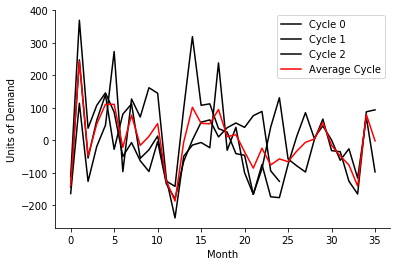

In [19]:
period = 36
cycleLen = period
numCycles = int(len(dfHS)/cycleLen + 0.5)
cycles = [dfHS.iloc[range(i*period,min((i+1)*period,len(dfHS)))]['R1'] for i in range(numCycles)]
ptsInCycles = [dfHS.iloc[range(i,len(dfHS['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

This code cell:
- Inserts the appropriate $C\left( m \right)$ value into the $C$ column in the DataFrame for each Month $m$.
- Plots the cyclicality component $C\left( m \right)$ is plotted with the $R1$ column to see how well the cyclicality component and it match.

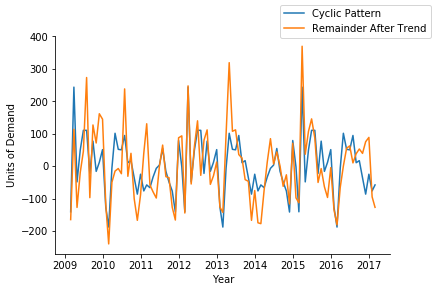

In [49]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(dfHS)/cycleLen + 0.5)
dfHS['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(dfHS)):
    dfHS.loc[dfHS.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
ax.plot(dfHS['C'],label='Cyclic Pattern')
ax.plot(dfHS['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

The code cell below does these:

- Computes the remaining residual home sales to be explained, $R2$, after subtracting the cyclical component, $C \left( m \right)$: this is the $\epsilon \left( m \right)$ in our model.
- Computes the error, $R2$, as a percentage of the demand time series.
- Computes the mathematical model 'fit', composed of the trend and cyclical components: $T\left( m \right) + C\left( m \right)$.
- Plots the fit of the model $T\left( m \right) + C\left( m \right)$ with the original data, $H \left( m \right)$.
- Computes the average absolute error of $R2Error$ of the original demand time series.
- Removes the sqErr column because it is no longer needed

Average Error:  0.10588656173826713
           YearMonth  homeSales      MovAvg          R1   R1Error           C  \
2009-02-28   2009-02        509  673.916667 -164.916667  1.324001 -140.893519   
2009-03-31   2009-03        782  668.666667  113.333333  0.855072  243.157407   
2009-04-30   2009-04        536  663.430556 -127.430556  1.237744  -48.750000   
2009-05-31   2009-05        638  657.611111  -19.611111  1.030738   49.513889   
2009-06-30   2009-06        686  640.375000   45.625000  0.933491  110.106481   
2009-07-31   2009-07        896  623.277778  272.722222  0.695623  110.069444   
2009-08-31   2009-08        520  617.333333  -97.333333  1.187179  -22.680556   
2009-09-30   2009-09        734  607.416667  126.583333  0.827543   76.759259   
2009-10-31   2009-10        673  601.916667   71.083333  0.894378  -16.351852   
2009-11-30   2009-11        760  598.847222  161.152778  0.787957   11.449074   
2009-12-31   2009-12        740  595.638889  144.361111  0.804917   50.65

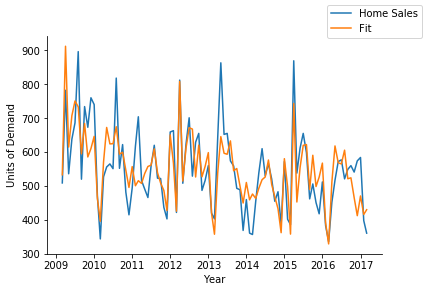

In [50]:
dfHS['R2'] = dfHS['R1'] - dfHS['C']
dfHS['R2Error'] = abs(dfHS['R2']/dfHS['homeSales'])
dfHS['fit'] = dfHS['MovAvg'] + dfHS['C']
dfHS.drop(['sqErr'],axis=1,inplace=True)
print('Average Error: ', sum(dfHS['R2Error'])/len(dfHS))
print(dfHS)
fig,ax = plt.subplots()
ax.plot(dfHS['homeSales'],label='Home Sales')
ax.plot(dfHS['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Here is a plot of the residual $R2$ for visualization purposes to observe any remaining patterns that we might want to capture, and also an autocorrelation analysis of the residual.

Correlation, lag  1     0.3407551921909781
Correlation, lag  2     0.13100301233823802
Correlation, lag  3     -0.1766559507914226
Correlation, lag  4     -0.1003590415909726
Correlation, lag  5     -0.16814690922501
Correlation, lag  6     -0.12415781580954244
Correlation, lag  7     -0.05822002914434892
Correlation, lag  8     -0.13054080263986692
Correlation, lag  9     -0.23781484496066232
Correlation, lag  10     -0.1222172789940625
Correlation, lag  11     -0.08231661390561465
Correlation, lag  12     0.06261644536400905
Correlation, lag  13     -0.13766331183104474
Correlation, lag  14     0.10809732254492026
Correlation, lag  15     0.011247451157934421
Correlation, lag  16     0.04436394548925096
Correlation, lag  17     -0.14415108233385596
Correlation, lag  18     0.052789137547610075
Correlation, lag  19     0.15053368772446965
Correlation, lag  20     -0.0466652928229702
Correlation, lag  21     -0.09679940427971702
Correlation, lag  22     -0.1701938623693834
Correlation,

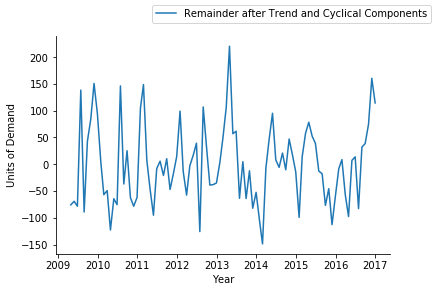

In [23]:
fig,ax = plt.subplots()
ax.plot(dfHS['R2'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHS['R2'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

A final graph to show the model versus the original data and, as well, the remander $R2$ to judge it relative to the original demand we were trying to fit.

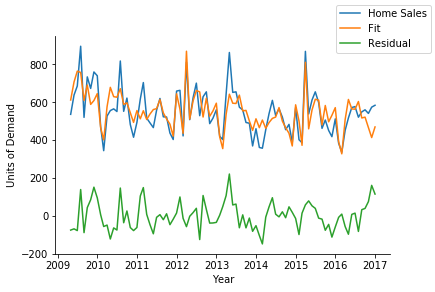

In [24]:
fig,ax = plt.subplots()
ax.plot(dfHS['homeSales'],label='Home Sales')
ax.plot(dfHS['fit'],label='Fit')
ax.plot(dfHS['R2'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

Trying different factors of cyclicality, it looks as though teh simple average is the best value:

In [28]:
for a in [0.1 * i for i in range(1,20)]:
    dfHS['aC'] = a*dfHS['C']
    dfHS['R3'] = dfHS['R1'] - dfHS['aC']
    dfHS['sqErr'] = dfHS['R3']**2
    print('Squared Error for a =','{:.1f}'.format(a),':',sum(dfHS['sqErr']))
    #print('Average Error: ', sum(dfHS['R2Error'])/len(dfHS))

Squared Error for a = 0.1 : 1122702.832199074
Squared Error for a = 0.2 : 999768.4848148153
Squared Error for a = 0.3 : 891297.0018287036
Squared Error for a = 0.4 : 797288.3832407407
Squared Error for a = 0.5 : 717742.6290509261
Squared Error for a = 0.6 : 652659.7392592594
Squared Error for a = 0.7 : 602039.7138657409
Squared Error for a = 0.8 : 565882.5528703708
Squared Error for a = 0.9 : 544188.2562731483
Squared Error for a = 1.0 : 536956.8240740743
Squared Error for a = 1.1 : 544188.2562731481
Squared Error for a = 1.2 : 565882.5528703702
Squared Error for a = 1.3 : 602039.7138657405
Squared Error for a = 1.4 : 652659.7392592593
Squared Error for a = 1.5 : 717742.6290509258
Squared Error for a = 1.6 : 797288.3832407407
Squared Error for a = 1.7 : 891297.001828704
Squared Error for a = 1.8 : 999768.4848148145
Squared Error for a = 1.9 : 1122702.8321990743


## Another Approach to Monthly Home Sales Time Series Decomposition

The prior approach to decomposing monthly home sales works well, but it is not amenable to a forecast of future sales because each point is computed with data from the future.  The approach used in this section differs only by how the trend cmoponent is computed, whcih is a moving average of some number of periods prior to the perio od sales we are trying to forecast.  That is, for each point it uses only data from the past relative to that point.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Average Squared Error per Month:  14189.294793028315
           YearMonth  homeSales      MovAvg         sqErr
2010-03-31   2010-03        527  713.566667  34807.121111
2010-04-30   2010-04        556  701.866667  21277.084444
2010-05-31   2010-05        565  697.933333  17671.271111
2010-06-30   2010-06        551  689.866667  19283.951111
2010-07-31   2010-07        818  691.266667  16061.337778
2010-08-31   2010-08        552  663.833333  12506.694444
2010-09-30   2010-09        622  658.866667   1359.151111
2010-10-31   2010-10        482  644.666667  26460.444444
2010-11-30   2010-11        415  631.200000  46742.440000
2010-12-31   2010-12        494  627.800000  17902.440000
2011-01-31   2011-01        617  622.233333     27.387778
2011-02-28   2011-02        704  623.000000   6561.000000
2011-03-31   2011-03        516  613.466667   9499.751111
2011-04-30   2011-04        491  610.766667  14344.054444
2011-05-31   2011-05        466  595.600000  16796.160000
2011-06-30   2011-0

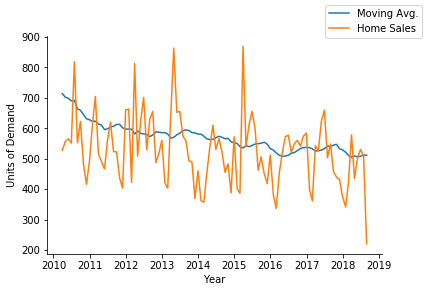

In [27]:
def sqErr(row):
    return (row[1] - row[2])**2
    
dfHSa = pd.read_csv('homeSales.csv')
dfHSa['MovAvg'] = np.NaN
dfHSa['sqErr'] = np.NaN
dfHSa.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2007, month=8, day=31), periods = len(dfHSa['homeSales']))
#print(len(data),'\n',data)

window = 30
for i in range(window+1,len(dfHSa)):
    dfHSa.loc[dfHSa.index[i],'MovAvg'] = sum(dfHSa.iloc[range(i-window-1,i)]['homeSales'])/float(window)
dfHSa['sqErr'] = dfHSa.apply(sqErr,axis='columns')
#print(data.head())
dfHSa.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(dfHSa['MovAvg'], label='Moving Avg.')
ax.plot(dfHSa['homeSales'], label='Home Sales')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Squared Error per Month: ',sum(dfHSa['sqErr'])/len(dfHSa))
print(dfHSa)

In [28]:
dfHSa['R1'] = dfHSa['homeSales'] - dfHSa['MovAvg']
dfHSa['R1Error'] = abs((dfHSa['homeSales'] - dfHSa['R1'])/dfHSa['homeSales'])
dfHSa.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format    
})

,YearMonth,homeSales,MovAvg,sqErr,R1,R1Error
2010-03-31 00:00:00,2010-03,527,713.6,"34,807.1",-186.567,1.35402
2010-04-30 00:00:00,2010-04,556,701.9,"21,277.1",-145.867,1.26235
2010-05-31 00:00:00,2010-05,565,697.9,"17,671.3",-132.933,1.23528
2010-06-30 00:00:00,2010-06,551,689.9,"19,284.0",-138.867,1.25203
2010-07-31 00:00:00,2010-07,818,691.3,"16,061.3",126.733,0.845069
2010-08-31 00:00:00,2010-08,552,663.8,"12,506.7",-111.833,1.2026
2010-09-30 00:00:00,2010-09,622,658.9,"1,359.2",-36.8667,1.05927
2010-10-31 00:00:00,2010-10,482,644.7,"26,460.4",-162.667,1.33748
2010-11-30 00:00:00,2010-11,415,631.2,"46,742.4",-216.2,1.52096
2010-12-31 00:00:00,2010-12,494,627.8,"17,902.4",-133.8,1.27085


Average Residual:  -44.28039215686276
Correlation, lag  1     0.26139365427306627
Correlation, lag  2     0.10498657768111407
Correlation, lag  3     0.10383505938041838
Correlation, lag  4     -0.1886295905008609
Correlation, lag  5     -0.14519435719226084
Correlation, lag  6     -0.0719196497635646
Correlation, lag  7     -0.1331146828176694
Correlation, lag  8     -0.13965228952253989
Correlation, lag  9     -0.041513821399192796
Correlation, lag  10     0.0026520514131592745
Correlation, lag  11     0.1643211127713046
Correlation, lag  12     0.29837285028569405
Correlation, lag  13     0.14368470699130775
Correlation, lag  14     -0.04303196541345698
Correlation, lag  15     -0.005491261700334031
Correlation, lag  16     -0.19846240061786916
Correlation, lag  17     -0.2132262843903361
Correlation, lag  18     -0.15721957959586197
Correlation, lag  19     -0.24932043294734885
Correlation, lag  20     -0.12181618792962301
Correlation, lag  21     -0.05554911240476115
Correlation, 

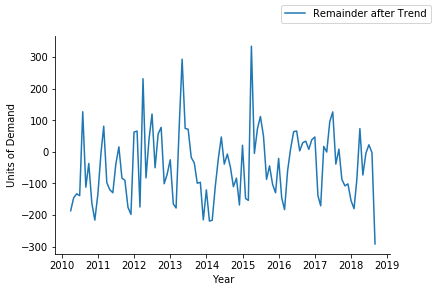

In [29]:
fig,ax = plt.subplots()
ax.plot(dfHSa['R1'],label='Remainder after Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Residual: ', sum(dfHSa['R1'])/len(dfHSa))

maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHSa['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

0 2010-03-31   -186.566667
2013-03-31     75.000000
2016-03-31    -59.133333
Freq: 36M, Name: R1, dtype: float64
1 2010-04-30   -145.866667
2013-04-30    293.000000
2016-04-30      9.433333
Freq: 36M, Name: R1, dtype: float64
2 2010-05-31   -132.933333
2013-05-31     73.966667
2016-05-31     63.633333
Freq: 36M, Name: R1, dtype: float64
3 2010-06-30   -138.866667
2013-06-30     71.300000
2016-06-30     65.866667
Freq: 36M, Name: R1, dtype: float64
4 2010-07-31    126.733333
2013-07-31    -17.700000
2016-07-31      2.933333
Freq: 36M, Name: R1, dtype: float64
5 2010-08-31   -111.833333
2013-08-31    -35.366667
2016-08-31     28.900000
Freq: 36M, Name: R1, dtype: float64
6 2010-09-30   -36.866667
2013-09-30   -99.433333
2016-09-30    33.633333
Freq: 36M, Name: R1, dtype: float64
7 2010-10-31   -162.666667
2013-10-31    -96.400000
2016-10-31      7.866667
Freq: 36M, Name: R1, dtype: float64
8 2010-11-30   -216.2
2013-11-30   -215.5
2016-11-30     38.0
Freq: 36M, Name: R1, dtype: float64
9

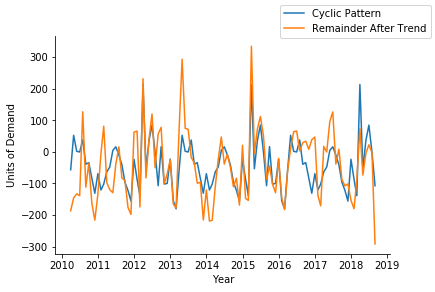

In [30]:
cycleLen = period   # see prior cell for computation of cyclicality period
avg = []            # a list to store the average demand for each period of the cycle
numCycles = int(len(dfHSa)/cycleLen + 0.5)
for j in range(cycleLen):
    if j + (numCycles-1) * cycleLen < len(dfHSa):
        d = dfHSa.iloc[range(j,j + (numCycles-1) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
    else:
        d = dfHSa.iloc[range(j,j + (numCycles-2) * cycleLen+1,cycleLen)]['R1']
        print(j,d)
        avg.append(sum(d)/len(d))
dfHSa['C'] = np.NaN
for i in range(len(dfHSa)):
    dfHSa.loc[dfHSa.index[i], 'C'] = avg[i % cycleLen]

fig,ax = plt.subplots()
ax.plot(dfHSa['C'],label='Cyclic Pattern')
ax.plot(dfHSa['R1'],label='Remainder After Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()


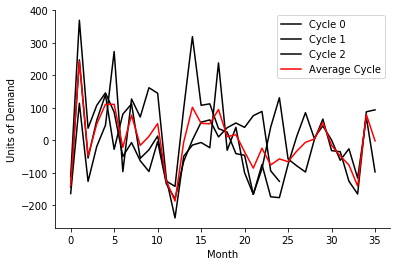

In [65]:
fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

           YearMonth  homeSales      MovAvg         sqErr          R1  \
2010-03-31   2010-03        527  713.566667  34807.121111 -186.566667   
2010-04-30   2010-04        556  701.866667  21277.084444 -145.866667   
2010-05-31   2010-05        565  697.933333  17671.271111 -132.933333   
2010-06-30   2010-06        551  689.866667  19283.951111 -138.866667   
2010-07-31   2010-07        818  691.266667  16061.337778  126.733333   
2010-08-31   2010-08        552  663.833333  12506.694444 -111.833333   
2010-09-30   2010-09        622  658.866667   1359.151111  -36.866667   
2010-10-31   2010-10        482  644.666667  26460.444444 -162.666667   
2010-11-30   2010-11        415  631.200000  46742.440000 -216.200000   
2010-12-31   2010-12        494  627.800000  17902.440000 -133.800000   
2011-01-31   2011-01        617  622.233333     27.387778   -5.233333   
2011-02-28   2011-02        704  623.000000   6561.000000   81.000000   
2011-03-31   2011-03        516  613.466667   9499.

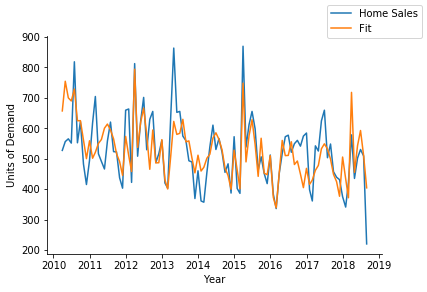

In [32]:
dfHSa['R2'] = dfHSa['R1'] - dfHSa['C']
dfHSa['R2Error'] = abs(dfHSa['R2']/dfHSa['homeSales'])
dfHSa['fit'] = dfHSa['MovAvg'] + dfHSa['C']
print(dfHSa)
fig,ax = plt.subplots()
ax.plot(dfHSa['homeSales'],label='Home Sales')
ax.plot(dfHSa['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Error: ', sum(dfHSa['R2Error']/len(dfHSa)))

Correlation, lag  1     0.36607601860455935
Correlation, lag  2     0.17717824059909718
Correlation, lag  3     0.05037594155915101
Correlation, lag  4     -0.03648114434725538
Correlation, lag  5     0.2193671767029301
Correlation, lag  6     0.12692528839724143
Correlation, lag  7     0.1508835980953447
Correlation, lag  8     0.0006065685997792922
Correlation, lag  9     -0.24362653546738522
Correlation, lag  10     -0.12024754148718543
Correlation, lag  11     0.05832273952647387
Correlation, lag  12     0.031088893201996426
Correlation, lag  13     -0.0720041886385924
Correlation, lag  14     -0.08212714387882643
Correlation, lag  15     -0.10420014558363878
Correlation, lag  16     -0.11210021206783544
Correlation, lag  17     -0.09169419951422685
Correlation, lag  18     -0.00996821665443028
Correlation, lag  19     -0.0933838301493063
Correlation, lag  20     -0.0913876975316234
Correlation, lag  21     -0.20885811421643155
Correlation, lag  22     -0.23445066360510794
Correlat

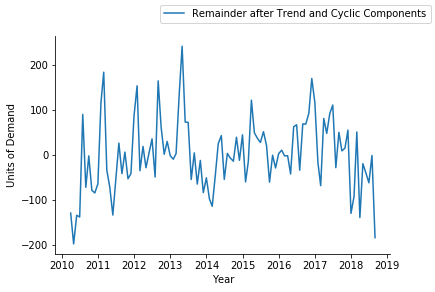

In [33]:
fig,ax = plt.subplots()
ax.plot(dfHSa['R2'], label='Remainder after Trend and Cyclic Components')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = dfHSa['R2'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

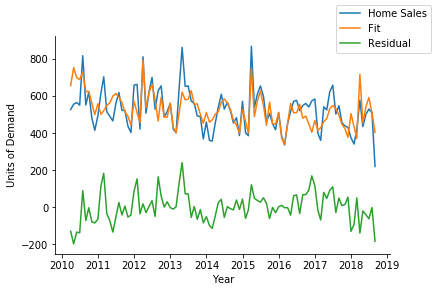

In [34]:
fig,ax = plt.subplots()
ax.plot(dfHSa['homeSales'],label='Home Sales')
ax.plot(dfHSa['fit'],label='Fit')
ax.plot(dfHSa['R2'],label='Residual')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()